# Language Modelling Interpretability Lab

**Goal**: Understand exactly what a neural language model learns by examining its weights.

A bigram model is the simplest possible language model - it predicts the next character using *only* the current character. This makes it fully interpretable: the entire model is just a 65x65 probability table.

In [ ]:
!git clone "https://github.com/deshcrete/leaf-technical-worksheets.git"
!mv leaf-technical-worksheets/* .
!mv week-3-language-modelling/* .

In [ ]:
import torch
from bigram_model import (
    setup_bigram_model,
    train_model,
    BigramLanguageModel,
    EmbeddingLanguageModel,
    SingleHeadAttentionModel,
    generate_with_temperature,
    sequence_probability,
    print_sequence_analysis,
    save_weights_snapshot
)
from visualization import (
    plot_training_history,
    visualize_learned_vs_actual,
    visualize_top_predictions,
    compare_embeddings_before_after,
    plot_token_embedding_pca,
    plot_token_embedding_similarity,
    find_similar_characters,
    show_attention
)

---
## 1. Setup

In [2]:
components = setup_bigram_model("input.txt", seed=1337)

text = components['text']
chars = components['chars']
vocab_size = components['vocab_size']
stoi = components['stoi']
itos = components['itos']
encode = components['encode']
decode = components['decode']
train_data = components['train_data']
val_data = components['val_data']
model = components['model']

# Save weights BEFORE training
weights_before = save_weights_snapshot(model)

print(f"Vocabulary: {vocab_size} characters")
print(f"Model has {vocab_size * vocab_size:,} learnable parameters (a {vocab_size}x{vocab_size} table)")

Vocabulary: 65 characters
Model has 4,225 learnable parameters (a 65x65 table)


---
## 2. Training

**Experiment**: Try different hyperparameters and see how they affect learning.

In [3]:
# =============================================
# HYPERPARAMETERS - MODIFY THESE!
# =============================================
batch_size = 32         # Try: 16, 32, 64, 128
max_iters = 10000       # Try: 1000, 5000, 10000
learning_rate = 1e-3    # Try: 1e-2, 1e-3, 1e-4

history = train_model(
    model, train_data, val_data,
    batch_size=batch_size,
    max_iters=max_iters,
    eval_interval=1000,
    lr=learning_rate
)

Step 0: Train Loss: 4.7296, Val Loss: 4.7229
Step 1000: Train Loss: 3.7320, Val Loss: 3.7312
Step 2000: Train Loss: 3.1288, Val Loss: 3.1292
Step 3000: Train Loss: 2.7997, Val Loss: 2.8051
Step 4000: Train Loss: 2.6383, Val Loss: 2.6451
Step 5000: Train Loss: 2.5597, Val Loss: 2.5700
Step 6000: Train Loss: 2.5140, Val Loss: 2.5367
Step 7000: Train Loss: 2.4998, Val Loss: 2.5145
Step 8000: Train Loss: 2.4786, Val Loss: 2.4961
Step 9000: Train Loss: 2.4768, Val Loss: 2.4963


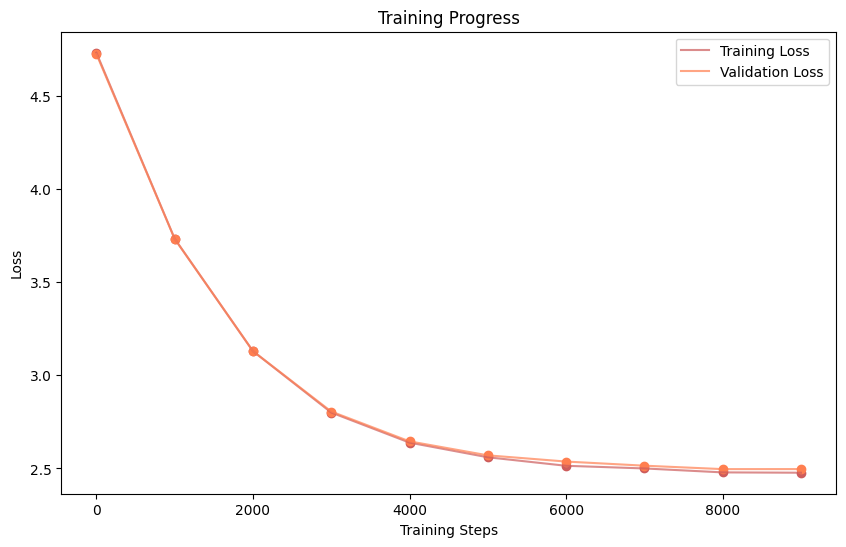

In [4]:
plot_training_history(history, eval_interval=1000)

---
## 3. What Did Training Change?

Compare the embedding table before and after training. The model started with random weights and learned to approximate the true bigram distribution.

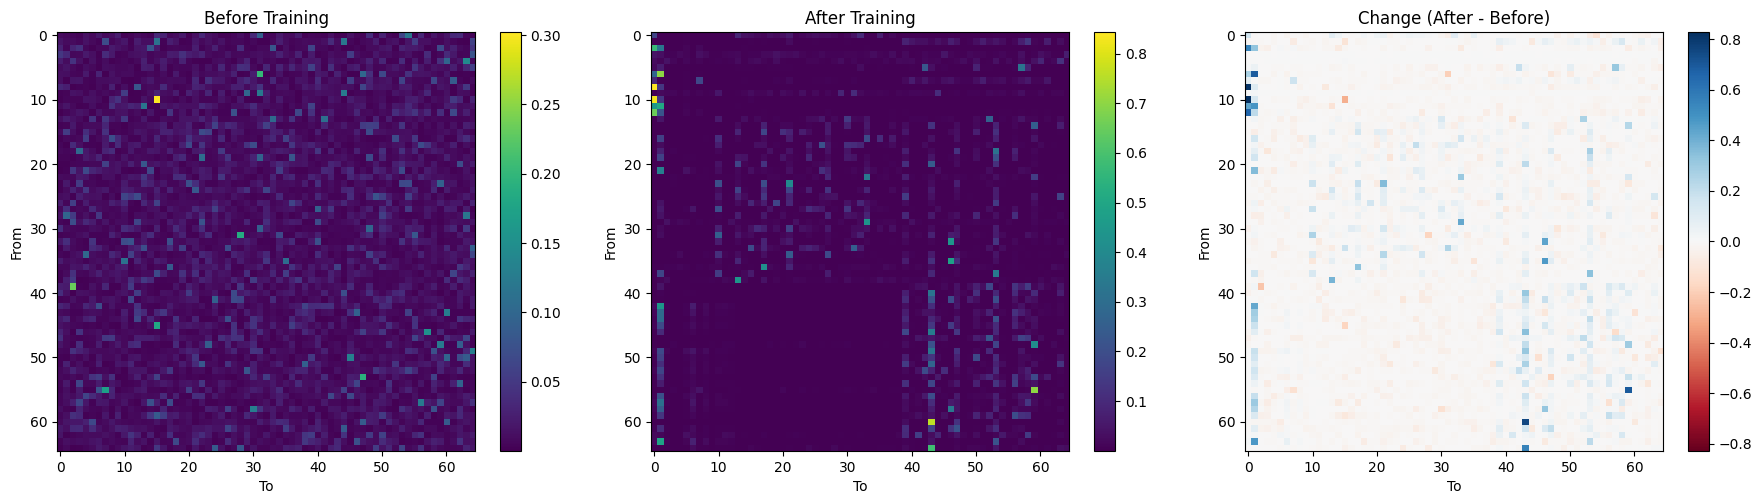

Total weight change (L2 norm): 233.1700


In [5]:
compare_embeddings_before_after(weights_before, model, chars)

---
## 4. Learned vs Actual: How Well Did It Learn?

The model should learn the true bigram frequencies from Shakespeare. Let's compare.

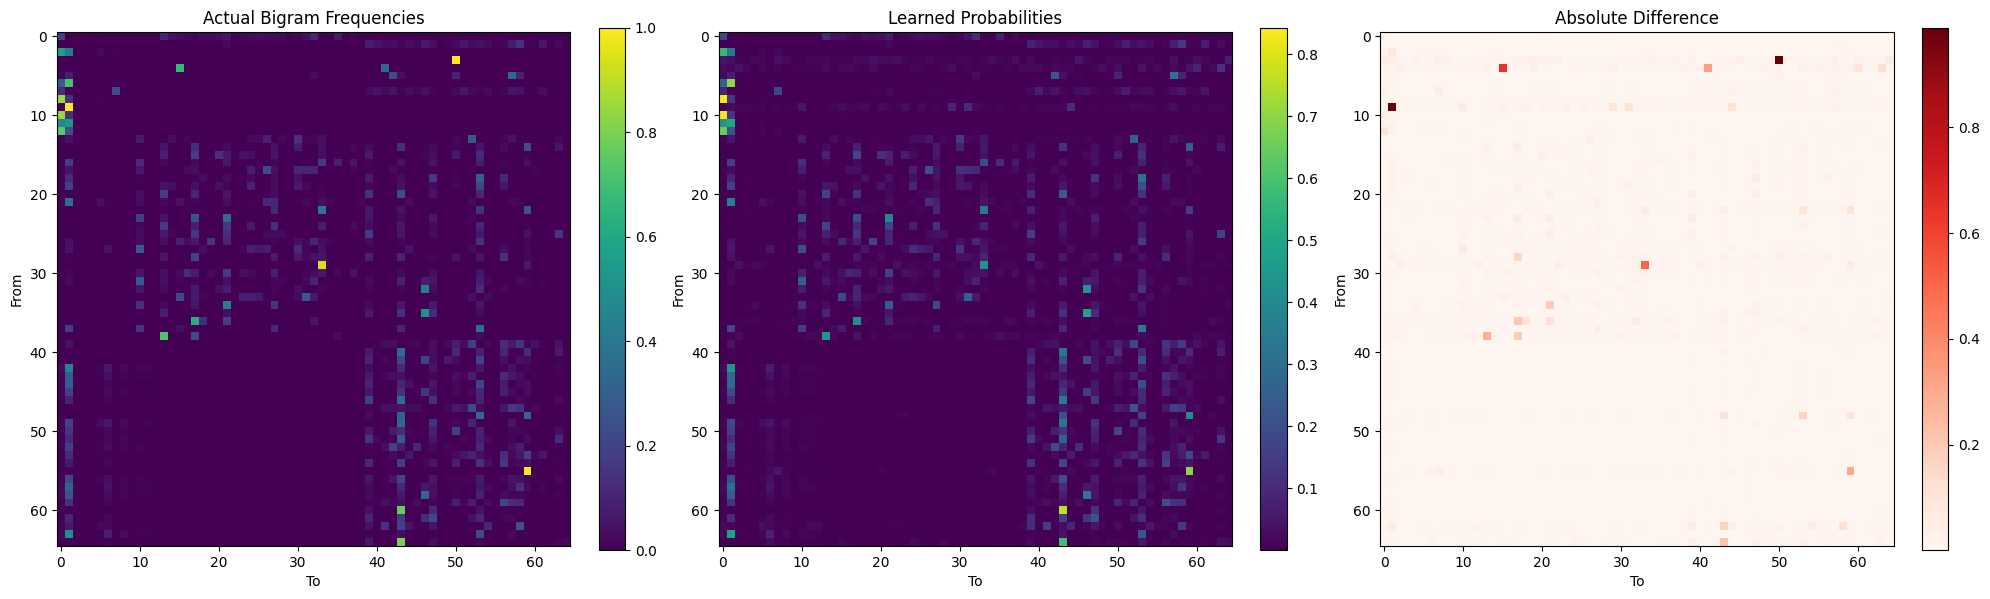

Mean absolute error: 0.004604
Max absolute error: 0.988361


In [6]:
visualize_learned_vs_actual(model, text, stoi, vocab_size, chars)

---
## 5. Probe the Model: What Does It Predict?

Look inside the model's "head" - what does it think comes after each character?

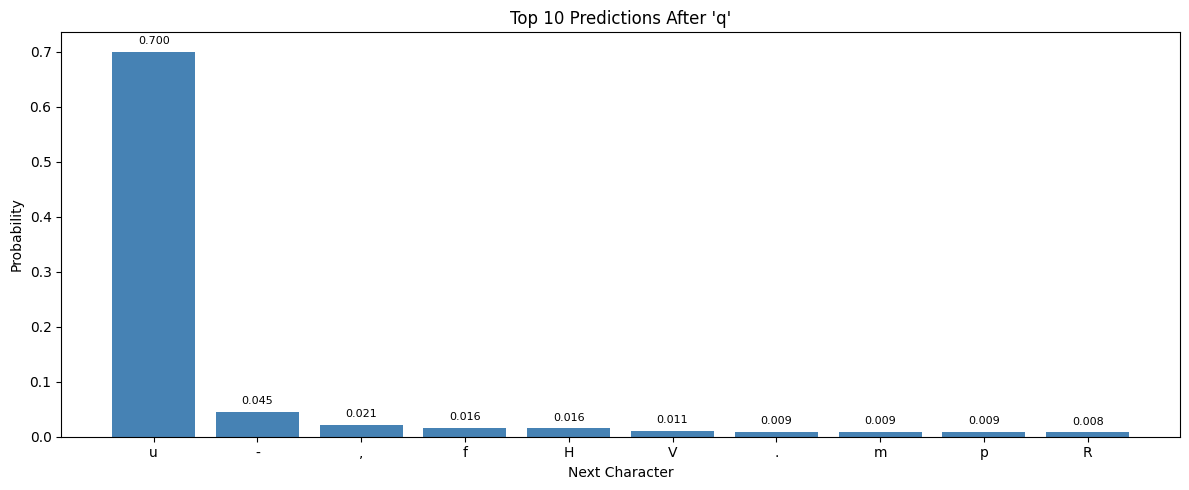

In [7]:
# =============================================
# TRY DIFFERENT CHARACTERS!
# =============================================
char_to_probe = 'q'  # Try: 't', 'e', ' ', 'q', 'x'

visualize_top_predictions(model, char_to_probe, stoi, itos, k=10)

**Questions to explore:**
- What does the model predict after 'q'? (Should be 'u')
- What about after 't'? After ' ' (space)?
- Why might some predictions be wrong?

---
## 6. Sequence Probability: The Key Interpretability Tool

Given any string, we can compute exactly how likely the model thinks it is - and see which transitions are the "weak links".

In [8]:
# =============================================
# TRY YOUR OWN SEQUENCES!
# =============================================
sequence = "the"  # Try: "the", "teh", "queen", "qeen", "hello"

print_sequence_analysis(model, sequence, stoi)

SEQUENCE ANALYSIS: 'the'

Overall Statistics:
  Total Probability: 1.18e-01
  Log Probability: -2.1378
  Perplexity: 2.9121

Transition Breakdown:
----------------------------------------
  't' -> 'h': 0.333649
  'h' -> 'e': 0.353420
----------------------------------------

Weakest transition: 't' -> 'h' (0.333649)


In [9]:
# Compare correct vs misspelled words
words = ["the", "teh", "thee", "there", "thier", "their"]

print(f"{'Word':<10} {'Probability':<15} {'Perplexity':<10}")
print("-" * 35)
for word in words:
    result = sequence_probability(model, word, stoi)
    print(f"{word:<10} {result['probability']:<15.2e} {result['perplexity']:<10.2f}")

Word       Probability     Perplexity
-----------------------------------
the        1.18e-01        2.91      
teh        1.89e-04        72.83     
thee       4.65e-03        5.99      
there      2.82e-03        4.34      
thier      2.73e-04        7.78      
their      9.88e-05        10.03     


---
## 7. Temperature: Controlling Randomness

Temperature scales the logits before sampling:
- **Low (0.2-0.5)**: More deterministic, picks high-probability characters
- **High (1.5-2.0)**: More random, explores unlikely characters

In [10]:
for temp in [0.2, 0.5, 1.0, 1.5, 2.0]:
    idx = torch.zeros((1, 1), dtype=torch.long)
    output = generate_with_temperature(model, idx, 80, temperature=temp)
    print(f"\nTemp={temp}: {decode(output[0].tolist())}")


Temp=0.2: 



The the t the the the t the the the t t the the the the and the the the t the

Temp=0.5: 
Whe t my f t manerind me th the se t lou the my t we bere the anghang m to loun 

Temp=1.0: 

Sha houmy bed, o?
YIIARat:
A:
What m mene sencon
Asil my thid


ct angempin.
ag

Temp=1.5: 
Mur?
ULT:

AEffaily ard, &V3! tho a:

Awia'szinks.ynk'Ph llad werayord Ag,'s
w!


Temp=2.0: 
IUMy:bre Ectd welesc&MUSAn!y hanvOsbEn:YQPULofeta uciXZu;-?, iKIff is s;.ZLYaPRI


---
## 8. Exercise: Build a Typo Detector

Use `sequence_probability` to detect likely misspellings. The model assigns lower probability to sequences with unusual bigrams.

In [11]:
def is_likely_typo(word1, word2, stoi):
    """Return True if word1 is more likely than word2 (word2 might be a typo)"""
    # YOUR CODE HERE
    # Hint: Compare perplexities - lower perplexity = more likely
    pass

# Test your function:
# is_likely_typo("their", "thier", stoi) should return True
# is_likely_typo("receive", "recieve", stoi) should return True

---
## 9. Reflection Questions

1. **Why can't the bigram model generate coherent sentences?** (Hint: what context does it use?)

2. **The model is a 65x65 table. What would we need to capture trigrams?** (Hint: think about dimensionality)

3. **Why is interpretability harder for larger models like GPT?**

---
## 10. Embedding Language Model: Can We Do Better?

The bigram model is limited - it only uses a direct lookup table. Let's try a model with:
- **Token embeddings**: Map each character to a learned vector
- **Positional embeddings**: Tell the model where each character is in the sequence
- **Linear projection**: Map the combined embedding back to vocabulary

This gives the model more capacity to learn patterns.

In [12]:
# =============================================
# EMBEDDING MODEL HYPERPARAMETERS
# =============================================
n_embd = 32          # Embedding dimension (try: 16, 32, 64, 128)
block_size = 8       # Context length

# Create the embedding model
emb_model = EmbeddingLanguageModel(vocab_size, n_embd=n_embd, block_size=block_size)

# Count parameters
bigram_params = sum(p.numel() for p in model.parameters())
emb_params = sum(p.numel() for p in emb_model.parameters())

print(f"Bigram model:   {bigram_params:,} parameters")
print(f"Embedding model: {emb_params:,} parameters")
print(f"\nEmbedding model is {emb_params/bigram_params:.1f}x larger")

Bigram model:   4,225 parameters
Embedding model: 4,481 parameters

Embedding model is 1.1x larger


In [13]:
# Train the embedding model
emb_history = train_model(
    emb_model, train_data, val_data,
    batch_size=32,
    block_size=block_size,
    max_iters=10000,
    eval_interval=1000,
    lr=1e-3
)

Step 0: Train Loss: 4.4871, Val Loss: 4.4815
Step 1000: Train Loss: 2.5840, Val Loss: 2.5908
Step 2000: Train Loss: 2.5177, Val Loss: 2.5257
Step 3000: Train Loss: 2.4965, Val Loss: 2.5081
Step 4000: Train Loss: 2.4832, Val Loss: 2.5029
Step 5000: Train Loss: 2.4731, Val Loss: 2.4961
Step 6000: Train Loss: 2.4782, Val Loss: 2.4944
Step 7000: Train Loss: 2.4716, Val Loss: 2.4986
Step 8000: Train Loss: 2.4681, Val Loss: 2.4897
Step 9000: Train Loss: 2.4741, Val Loss: 2.4933


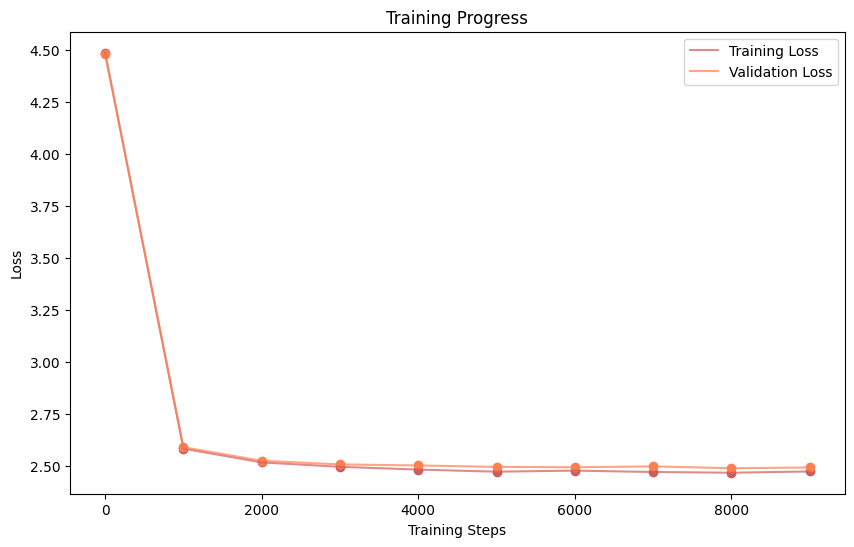

In [14]:
plot_training_history(emb_history, eval_interval=1000)

In [15]:
# Compare final losses
bigram_final = history[-1]['val']
emb_final = emb_history[-1]['val']

print(f"Final Validation Loss:")
print(f"  Bigram model:    {bigram_final:.4f}")
print(f"  Embedding model: {emb_final:.4f}")
print(f"\nImprovement: {bigram_final - emb_final:.4f} ({(bigram_final - emb_final)/bigram_final * 100:.1f}%)")

Final Validation Loss:
  Bigram model:    2.4963
  Embedding model: 2.4933

Improvement: 0.0030 (0.1%)


In [16]:
# Generate text with the embedding model
idx = torch.zeros((1, 1), dtype=torch.long)
emb_output = emb_model.generate(idx, 200)
print("Generated text (Embedding model):")
print("-" * 40)
print(decode(emb_output[0].tolist()))

Generated text (Embedding model):
----------------------------------------

RXERGLAl, wousthak pe,
Anid I utithund t F urca r cIENEENI jet yo har:
A: nd' bu pe.
IXENoon iour nsyor, mouspid.


CHe
Tind, mou;
Hol pur wing isprourrin.
ABERNCENo d mer thuer s s ouspat pakigu fo p


---
## 11. Interpreting the Embedding Model

The embedding model learned a **32-dimensional vector** for each character. But what do these vectors mean? Let's visualize them!

### Key Concept: Cosine Similarity
Cosine similarity measures how much two vectors "point in the same direction":
- **1.0** = identical direction (very similar)
- **0.0** = perpendicular (unrelated)  
- **-1.0** = opposite directions (very different)

Think of it like comparing arrows: two arrows pointing the same way are similar, regardless of their length.

### 11.1 Token Embeddings: Which Characters Are Similar?

PCA compresses the 32-dimensional embeddings down to 2D so we can plot them. Characters that appear **close together** have similar embeddings - the model thinks they behave similarly!

**Questions to explore:**
- Do vowels (a, e, i, o, u) cluster together?
- Are uppercase and lowercase versions of the same letter close?
- Where is the space character? Why might it be in a special location?

### 11.2 Similarity Heatmap

This shows the cosine similarity between **every pair** of characters. Red = similar, Blue = dissimilar.

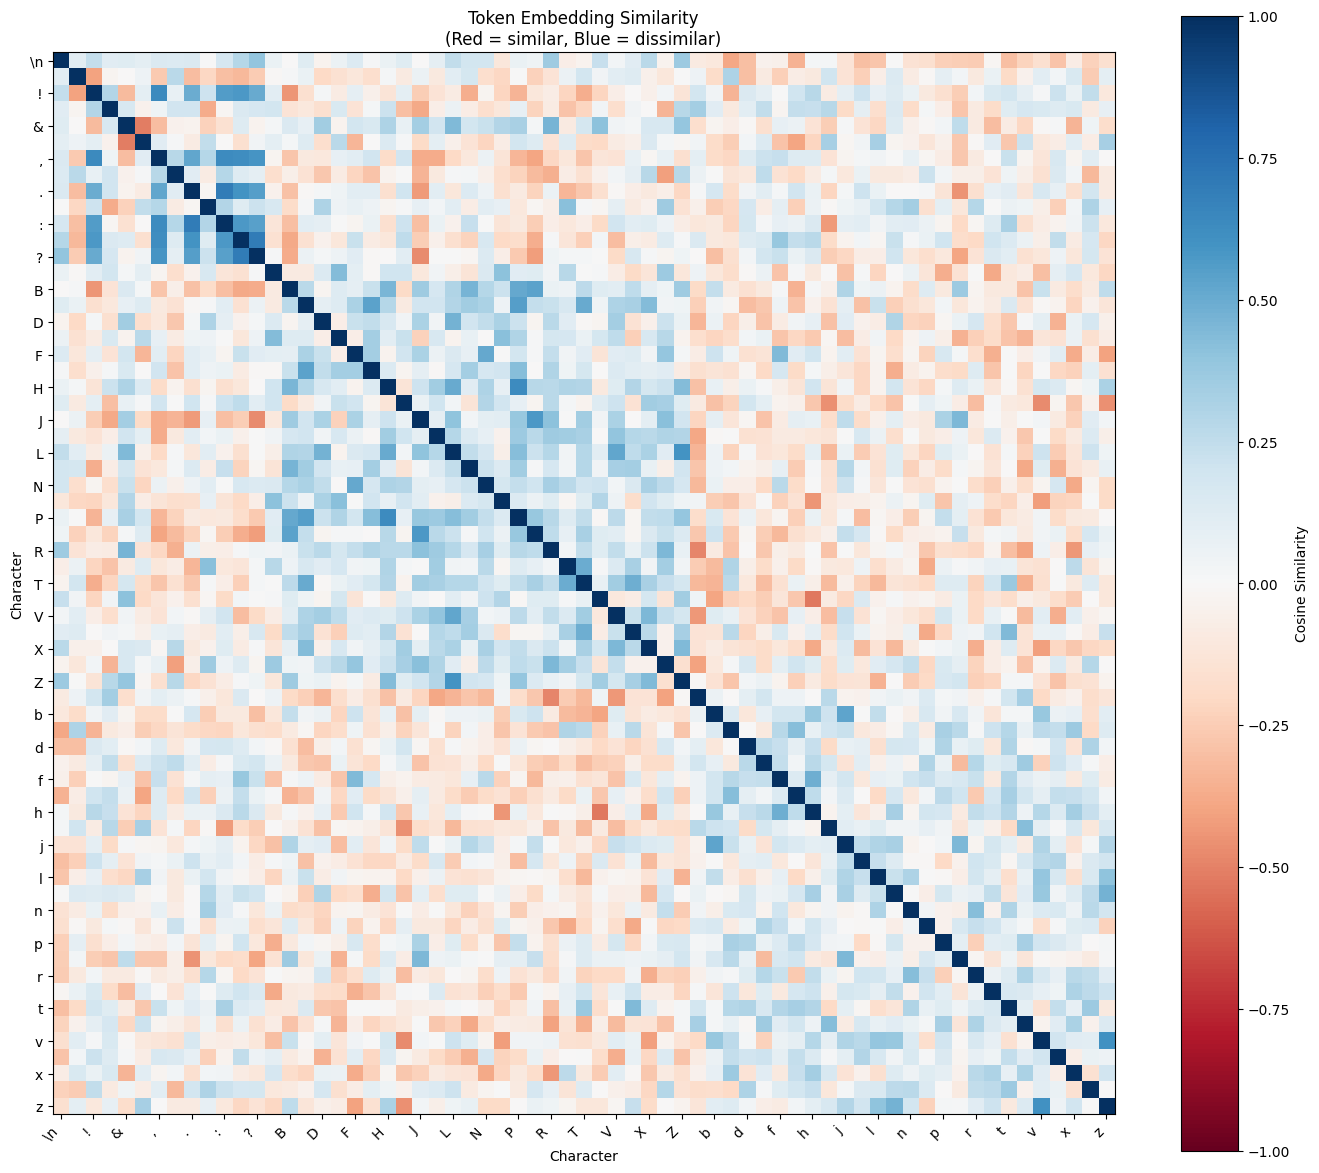

In [18]:
# Heatmap of character similarities
plot_token_embedding_similarity(emb_model, chars)

### 11.3 Find Similar Characters

Pick a character and find which other characters have the most similar embeddings.

In [19]:
# =============================================
# TRY DIFFERENT CHARACTERS!
# =============================================
char_to_explore = 'e'  # Try: 'a', 't', ' ', 'T', 'q'

similar = find_similar_characters(emb_model, char_to_explore, chars, stoi, top_k=10)

print(f"Characters most similar to '{char_to_explore}':")
print("-" * 30)
for char, sim in similar:
    print(f"  '{repr(char)[1:-1]}': {sim:.3f}")

Characters most similar to 'e':
------------------------------
  'u': 0.353
  'o': 0.297
  'r': 0.287
  'h': 0.273
  'd': 0.272
  '-': 0.250
  '$': 0.244
  'f': 0.239
  ',': 0.214
  'w': 0.205


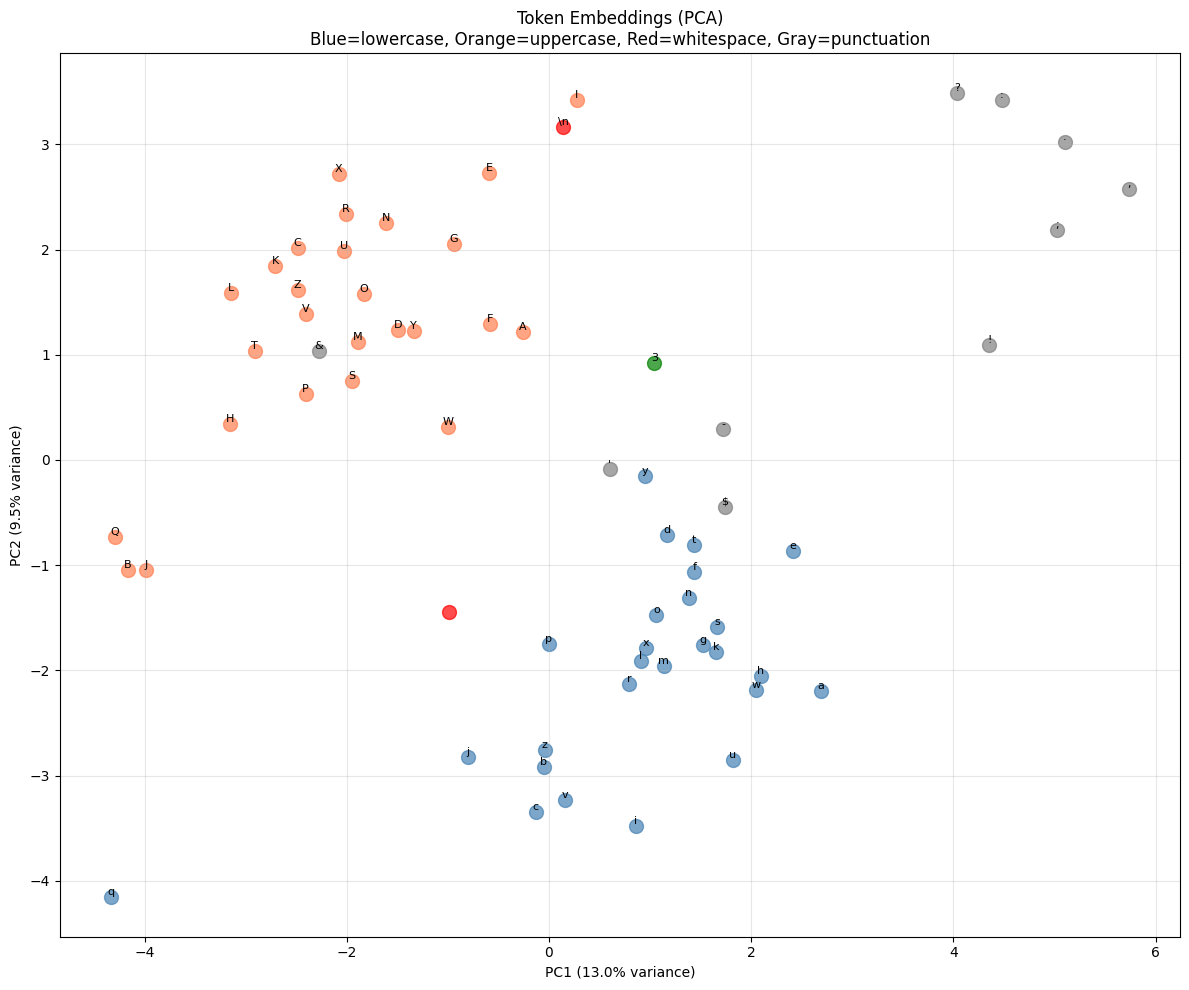

In [20]:
# Visualize character embeddings in 2D
plot_token_embedding_pca(emb_model, chars)

---
## 12. Extensions (For Further Exploration)

If you want to dig deeper, here are some more advanced investigations:

### Extension 1: Embedding Arithmetic
Do the embeddings capture relationships? For example:
- Does `embedding('k') - embedding('K')` approximately equal `embedding('a') - embedding('A')`?
- This would mean the model learned a "capitalization direction"

### Extension 2: The Linear Head (lm_head)
The `lm_head` layer maps embeddings to predictions. You could:
- Visualize which embedding dimensions matter most for predicting each character
- Compute an "effective bigram table" by doing `softmax(token_embeddings @ lm_head.T)`

### Extension 3: t-SNE Visualization
t-SNE is another dimensionality reduction technique (like PCA) that often reveals clusters better. It's more computationally expensive but can show non-linear structure.

### Extension 4: Probing Specific Sequences
Feed a sequence like "the" through the model and visualize:
- How the combined (token + position) embeddings differ at each position
- What the model predicts at each position

### Extension 5: Compare Before vs After Training
Save the embeddings before training and compare to after. Which characters changed the most?

---
## 13. Self-Attention: The Key Innovation in Transformers

The embedding model has a critical limitation: **each position makes its prediction independently**. There's no way for tokens to "communicate" with each other.

### The Problem

Consider predicting the next word in: *"The cat sat on the ___"*

- The word "sat" is very important (tells us we need a location)
- "The" and "cat" are less relevant

A good model should **pay more attention** to "sat" than to "The". But our embedding model treats all positions the same!

### The Solution: Self-Attention

**Self-attention** lets each token look at previous tokens and decide how much to pay attention to each one. The key insight:

> Instead of treating all past tokens equally, let the model **learn** what to pay attention to.

Each token produces:
- **Query (Q)**: "What am I looking for?"
- **Key (K)**: "What do I contain?"
- **Value (V)**: "What information should I provide?"

Attention = how well queries match keys. High match → pay more attention.

**This is why ChatGPT can remember what you said earlier in a conversation!**

In [ ]:
# =============================================
# ATTENTION MODEL HYPERPARAMETERS
# =============================================
n_embd = 32          # Embedding dimension
block_size = 8       # Context length

# Create the attention model
attn_model = SingleHeadAttentionModel(vocab_size, n_embd=n_embd, block_size=block_size)

# Count parameters
attn_params = sum(p.numel() for p in attn_model.parameters())

print(f"Model Comparison:")
print(f"  Bigram model:     {bigram_params:,} parameters")
print(f"  Embedding model:  {emb_params:,} parameters")
print(f"  Attention model:  {attn_params:,} parameters")

In [31]:
# Train the attention model
attn_history = train_model(
    attn_model, train_data, val_data,
    batch_size=32,
    block_size=block_size,
    max_iters=10000,
    eval_interval=1000,
    lr=1e-3
)

NameError: name 'attn_model' is not defined

In [ ]:
# Compare all three models
print("=" * 50)
print("FINAL VALIDATION LOSS COMPARISON")
print("=" * 50)
print(f"  Bigram model:     {bigram_final:.4f}")
print(f"  Embedding model:  {emb_final:.4f}")
print(f"  Attention model:  {attn_history[-1]['val']:.4f}")

# Generate text comparison
print("\n" + "=" * 50)
print("TEXT GENERATION COMPARISON")
print("=" * 50)

idx = torch.zeros((1, 1), dtype=torch.long)
print("\n--- Bigram Model ---")
print(decode(model.generate(idx.clone(), 150)[0].tolist()))

print("\n--- Embedding Model ---")
print(decode(emb_model.generate(idx.clone(), 150)[0].tolist()))

print("\n--- Attention Model ---")
print(decode(attn_model.generate(idx.clone(), 150)[0].tolist()))

In [ ]:
# Visualize what the attention head learned
show_attention(attn_model, "the king", encode, decode)

---
## 14. What More Could We Do? (Limited Compute Considerations)

With limited compute, here are the most impactful improvements, roughly ordered by bang-for-buck:

### Already Implemented
1. **Positional Embeddings** - Lets model know where tokens are
2. **Single Self-Attention Head** - Data-dependent context aggregation

### High-Impact, Low-Compute Additions
3. **Residual Connections** - Add input back to output: `x = x + attention(x)`. Helps with gradient flow and lets the model choose to "pass through" information.

4. **Layer Normalization** - Stabilizes training, especially important as models get deeper.

5. **Multi-Head Attention** - Instead of one big attention head, use multiple smaller heads. Each head can learn different patterns (one might focus on adjacent chars, another on vowels, etc.)

6. **Feed-Forward Network** - After attention, apply a small MLP: `x = x + FFN(x)`. Gives the model per-position computation ability.

### Architecture Summary (What GPT Does)
```
for each layer:
    x = x + MultiHeadAttention(LayerNorm(x))
    x = x + FeedForward(LayerNorm(x))
```

### The "Bitter Lesson" for Limited Compute
With truly limited compute, focus on:
- **Better data** - Clean, diverse text helps more than architecture tweaks
- **Longer training** - Often undertrained; try 2-3x more iterations  
- **Hyperparameter tuning** - Learning rate and batch size matter a lot
- **Simpler models trained longer** beat complex models trained briefly